In [1]:
from luxai_s2.env import LuxAI_S2
from luxai_s2.map.board import Board
from luxai_s2.map_generator.generator import GameMap
import matplotlib.pyplot as plt
import matplotlib
import logging
import numpy as np
from luxai_s2.utils import my_turn_to_place_factory
from agents_experiments import (reset_w_custom_board, IdleAgent, interact)
from obs import CenteredObservation, RobotCenteredObservation
from robots import Enacter
import uuid


logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

matplotlib.rc('font', size=14)

from luxai_s2.env import EnvConfig
    
class ControlledAgent:
    factories: dict
    actions: dict
    calls_to_act: int = 0
    
    def __init__(self, player: str, env_cfg: EnvConfig) -> None:
        self.player = player
        self.opp_player = "player_1" if self.player == "player_0" else "player_0"
        np.random.seed(0)
        self.env_cfg: EnvConfig = env_cfg
            
    def early_setup(self, step: int, obs, remainingOverageTime: int = 60):
        if step == 0:
            return dict(faction="AlphaStrike", bid=0)
        else:
            myteam = obs['teams'][self.player]

            try:
                water_left = myteam['water']
            except AttributeError:
                print(myteam)
                raise 
            metal_left = myteam['metal']

            # how many factories you have left to place
            factories_to_place = myteam['factories_to_place']
            
            # whether it is your turn to place a factory
            my_turn_to_place = my_turn_to_place_factory(myteam['place_first'], step)
            
            if factories_to_place > 0 and my_turn_to_place:
                inner_list = list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1)))
                potential_spawns = np.array(inner_list)    
                selected_location_ix = 0
                spawn_loc = potential_spawns[selected_location_ix]
                return dict(spawn=spawn_loc, metal=150, water=150)
            return dict()


    def act(self, step: int, obs, remainingOverageTime: int = 60):
        self.calls_to_act += 1
        actions = dict()
        game_state: GameState = obs_to_game_state(step, self.env_cfg, obs)
        factories = game_state.factories[self.player]
        self.factories = factories
        logger.debug(f"{type(factories)=}")
        logger.debug(f"{factories=}")
        for unit_id, factory in factories.items():
            if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
            factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
                actions[unit_id] = factory.build_heavy()
        self.actions = actions
        return actions
    
    def debug_act(self, step: int, obs, remainingOverageTime: int = 60):
        observation = CenteredObservation(obs, self.player)
        
        # who am I?
        logger.debug(f'I am {observation.myself}')
        
        # what turn is it?
        logger.debug(f'{step=}  {remainingOverageTime=}')
        
        self.calls_to_act += 1
        actions = dict()
        
        # how many factories does each player have, and where?
        def count_and_locate_factories(fac):
            count = len(fac)
            locations = list(v['pos'] for v in fac.values())
            return count, locations

        myteam_ = observation.my_factories
        opp_team_ = observation.opp_factories
        try:
            my_factories = count_and_locate_factories(myteam_)
            logger.debug(f'{my_factories=}')
        except KeyError:
            logger.debug('no factories found in controlled agent\'s team')
            
        try:
            opponents_factories =count_and_locate_factories(opp_team_)
            logger.debug(f'{opponents_factories=}')
        except KeyError:
            logger.debug('no factories found in opponent agent\'s team')
            
        
        # where are ice and ore?
        logger.debug('where are ice and ore?')
        logger.debug(f'{observation.ice_map.shape=}  {observation.ice_map.dtype=}  {observation.ice_map.sum()=}')
        logger.debug(f'{observation.ore_map.shape=}  {observation.ore_map.dtype=}  {observation.ore_map.sum()=}')
        
        factories = obs['factories'][self.player]
        self.factories = factories
        
        for unit_id, factory in factories.items():
            if factory['power'] >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
            factory['cargo']['metal'] >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
                try:
                    actions[unit_id] = 1  # build heavy
                except AttributeError:
                    print(obs)
                    raise
        
#         logging.debug(f'max queue size={self.env_cfg.UNIT_ACTION_QUEUE_SIZE}')
        
        for unit_id in observation.my_units.keys():
            robot_obs = RobotCenteredObservation(obs, unit_id)
            robot = Enacter(robot_obs, self.env_cfg)
            
            logging.debug(f'Hi, I am robot {robot_obs.myself}')
            if not robot_obs.queue:
                actions[unit_id] = [robot.move_right(finite=5)]
            logging.debug(f'{robot_obs.state=}')
                    
        self.actions = actions
        
        # what were my returned actions?
        logger.debug(f'{actions=}')
        return actions

In [2]:
# key-values of dict below should match attributes present in this class
# https://github.com/aernesto/Lux-Design-S2/blob/adrian/luxai_s2/luxai_s2/config.py#L34
environment_config = dict(
        max_episode_length=350,  # how many total turns in game
        CYCLE_LENGTH=50,
        DAY_LENGTH=50,  # so no night
        MAX_RUBBLE=0,  # disable rubble   
        MIN_FACTORIES=2,  
        MAX_FACTORIES=2
    )
env = LuxAI_S2(**environment_config)
custom_rubble = np.zeros((env.env_cfg.map_size,) * 2, dtype=np.int64)

# Let's put a single ice at 30,30
custom_ice = np.zeros_like(custom_rubble)
custom_ice[30, 30] = 1

# Let's put a single ore at 21, 21
custom_ore = np.zeros_like(custom_rubble)
custom_ore[21, 21] = 1

custom_symmetry = None


custom_map_ = GameMap(custom_rubble, custom_ice, custom_ore, custom_symmetry)

simple_board = Board(
    seed=env.seed_rng.randint(0, 2**32 - 1, dtype=np.int64), 
    env_cfg=env.env_cfg,
    existing_map=custom_map_
)

obs, env = reset_w_custom_board(env, seed=41, custom_board=simple_board)
    
# source code of reset() method: 
# https://github.com/aernesto/Lux-Design-S2/blob/adrian/luxai_s2/luxai_s2/env.py#L175
# obs = env.reset(seed=41) # resets an environment with a seed

In [3]:
# first player cannot place factory on any boundary, so inner square has dimensions 46x46
# the 2 isolated resources remove each 9 tiles from the potential spawn locations
46*46- 9*2

2098

In [4]:
2098 -28

2070

In [5]:
# recreate our agents and run
agents = {}
for player, agent_constructor in zip(env.agents, [IdleAgent, ControlledAgent]):
    agents[player] = agent_constructor(player, env.state.env_cfg) 
last_obs = interact(env, agents, 3, custom_board=simple_board)

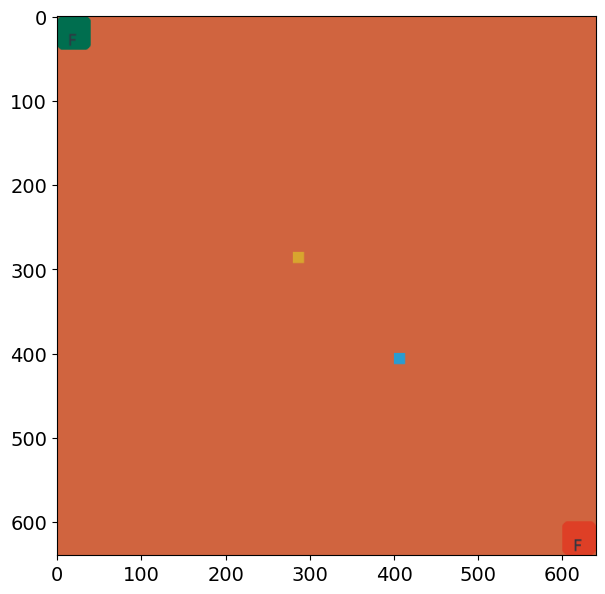

In [6]:
#video above is missing bottom pixels for some reason 
logger.setLevel(logging.INFO)
img = env.render("rgb_array", width=640, height=640)
f, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img);

In [7]:
logger.setLevel(logging.INFO)

filename = str(uuid.uuid4()) + '.mp4'
file_path = '/home/adrian_admin/prog/kaggle/lux-ai-2/Lux-Design-S2/data/experiments/adrian/'

for player, agent_constructor in zip(env.agents, [IdleAgent, ControlledAgent]):
    logging.debug(player)
    agents[player] = agent_constructor(player, env.state.env_cfg) 

    
_ = interact(
    env, 
    agents, 
    13, 
    animate_=file_path + filename, 
    break_at_first_action=False, 
    debug=True, 
    custom_board=simple_board
)
# print(last_obs)

INFO:root:writing /home/adrian_admin/prog/kaggle/lux-ai-2/Lux-Design-S2/data/experiments/adrian/7decdf00-2449-449b-95b5-51e05f4f4624.mp4


In [8]:
from IPython.display import Video

In [9]:
Video(file_path + filename, embed=True)

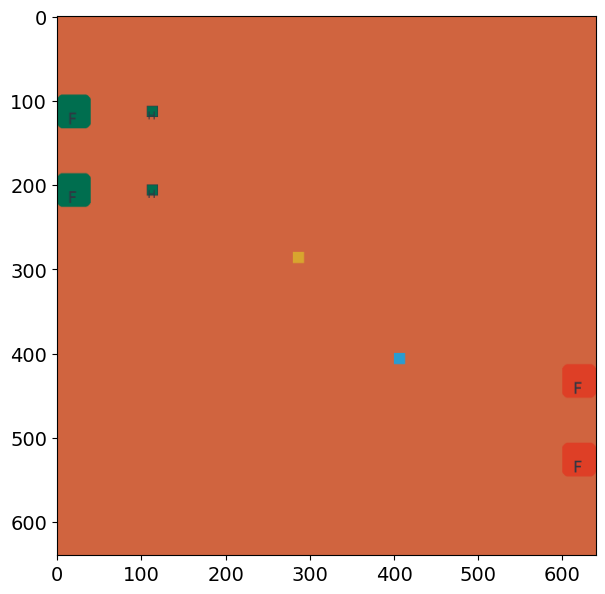

In [10]:
#video above is missing bottom pixels for some reason 
img = env.render("rgb_array", width=640, height=640)
f, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img);